The final budget of the trading strategy is 243944 USD
Total number of trades is 27


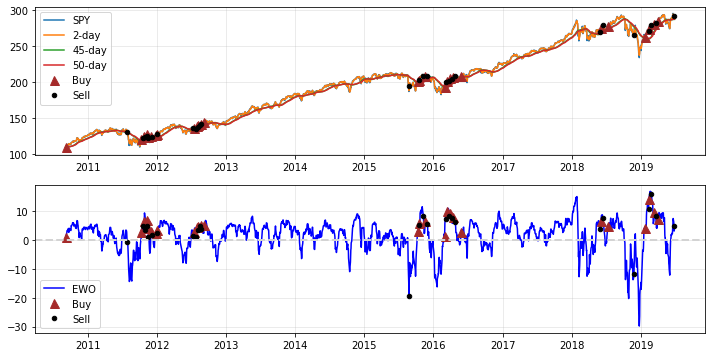

In [4]:
#3.3 EWO Revision 2 with the Best Combination
#EWO = Elliott Wave Oscillator
#The current code only focuses on the long position

import import_ipynb
import EWO

#Dataframe Initialization
#target_market_ticker = EWO.Ewo(target_market_ticker, start_date(yyyy-mm-dd), end_date(yyyy-mm-dd))
SPY = EWO.Ewo('SPY', '2010-06-28', '2019-06-28')

#Process data and return market & market_buy_init dataframes
#market, market_buy_init = target_market_ticker.data_process(fast_sma, slow_sma, \
#longer_sma, n_day_EWO_slope, n_day_closing_price, use_filter4(0 or 1))
market, market_buy_init = SPY.data_process(2, 45, 50, 5, 125, 0)

#Backtesting of trading strategy on the target_market_ticker from start_date to end_date
#print the final budget and total number of trades & return market_buy and market_sell dataframes
#market_buy, market_sell = target_market_ticker.backtest(budget, market, market_buy_init)
market_buy, market_sell = SPY.backtest(100000, market, market_buy_init)

#Visualize the trading result with graphs for price trend and the EWO value
#target_market_ticker.visualize(market, market_buy, market_sell)
SPY.visualize(market, market_buy, market_sell)

In [5]:
market_buy.head()

,Date,Open,Close,2-day,45-day,50-day,EWO,Filter1,Filter2,Filter3,Exit1,Exit2
Day,,,,,,,,,,,,
51,2010-09-08,109.860001,110.410004,110.025002,109.114223,108.5080,0.910779,0,1,1,0,0
328,2011-10-12,120.599998,120.750000,120.224998,117.329778,117.5218,2.895221,1,1,1,0,-1
336,2011-10-24,124.169998,125.489998,124.730000,118.293556,118.2048,6.436444,1,1,1,0,-1
347,2011-11-08,126.919998,127.879997,127.070000,120.058000,120.0458,7.012000,1,1,1,0,-1
353,2011-11-16,124.809998,124.080002,125.080002,120.963112,120.6416,4.116890,1,1,1,0,-1


In [6]:
market_sell.head()

,Date,Open,Close,2-day,45-day,50-day,EWO,Filter1,Filter2,Filter3,Exit1,Exit2
Day,,,,,,,,,,,,
275,2011-07-28,130.600006,130.220001,130.410004,130.958444,131.195799,-0.548440,0,0,0,-1,-1
335,2011-10-21,123.089996,123.970001,122.815002,118.008000,118.057400,4.807002,1,1,1,0,-1
343,2011-11-02,123.830002,123.989998,122.994999,119.438667,119.402200,3.556332,1,0,1,-1,-1
350,2011-11-11,125.830002,126.660004,125.490002,120.477778,120.231800,5.012224,1,0,1,-1,-1
355,2011-11-18,122.500000,121.980003,122.045002,120.988445,120.824200,1.056557,0,0,1,-1,-1
